# PyTorch实例3：微博谣言检测
作者：杨邦

邮箱：yangbang@pku.edu.cn

日期：2022-09-28

## 3.1 导入程序包

In [1]:
# !pip install jieba

In [2]:
import json, os
import pickle
from tqdm import tqdm

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 设置随机种子保证可复现
import random
SEED = 729608
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# os python hash seed, make experiment reproducable
os.environ['PYTHONHASHSEED'] = str(SEED)
# gpu algorithom 
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Generator SEED
Generator = torch.Generator()
Generator.manual_seed(SEED)

/home/charon/anaconda3/envs/qbw_base/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3.2 数据预处理

### 3.2.1 数据下载

In [3]:
# !git clone https://github.com/thunlp/Chinese_Rumor_Dataset.git

In [4]:
!ls ./Chinese_Rumor_Dataset
!ls ./Chinese_Rumor_Dataset/CED_Dataset/

CED_Dataset  README.md	rumors_v170613.json
non-rumor-repost  original-microblog  README.md  rumor-repost


### 3.2.2 获取微博文本及其配对标签

In [5]:
# 数据来源文件夹 -- 内含多个json文件
non_rumor = './Chinese_Rumor_Dataset/CED_Dataset/non-rumor-repost'
rumor = './Chinese_Rumor_Dataset/CED_Dataset/rumor-repost'
original = './Chinese_Rumor_Dataset/CED_Dataset/original-microblog'

non_rumor_data = []
rumor_data = []

# 遍历文件夹，读取文本数据
print('开始读取数据')
for file in tqdm(os.listdir(original)):
    try:
        data = json.load(open(os.path.join(original, file), 'rb'))['text']
    except:
        continue

    is_rumor = (file in os.listdir(rumor))
    if is_rumor:
        rumor_data.append(data)
    else:
        non_rumor_data.append(data)

print('结束, 有{}条谣言, 有{}条非谣言!'.format(len(rumor_data), len(non_rumor_data)))
print(non_rumor_data[-2:])
print('-'*20)
print(rumor_data[-2:])


# 把数据储存到指定地方 -- 统一到2个txt文件
pth = './rumor_detection_data'
if not os.path.exists(pth):
    os.makedirs(pth)

good_file = os.path.join(pth, 'non_rumor.txt')
bad_file = os.path.join(pth, 'rumor.txt')

# with open(good_file, 'w', encoding='utf-8') as f:
#     f.write('\n'.join(non_rumor_data))
# with open(bad_file, 'w', encoding='utf-8') as f:
#     f.write('\n'.join(rumor_data))

开始读取数据


100%|██████████| 3389/3389 [00:01<00:00, 2059.92it/s]

结束, 有1538条谣言, 有1849条非谣言!
['＂有时最坚强的人是 - 不因缺陷而不爱，关起门才哭泣，和打没有人知道的仗。＂(Sometimes the strongest people are the one love beyond all faults, cry behind closed doors and fight battles that nobody knows about。)', '想研究外星人么？ 去爱大吧！！ 爱丁堡大学计划今年年底第一次提供寻找外星人的课程。。"Introduction to Astrobiology and the Search for Extraterrestrial Life" 将由学校的星际生物学教授Charles Cockell 讲授！']
--------------------
['【#越南乳瓜#】神奇的越南乳瓜，神似女性的乳房，颜色略呈粉色。乳瓜成熟果实含葡萄糖、果糖、蔗糖、胡萝卜素、维生素C、酒石酸、枸椽酸、苹果酸等。未成熟果实的汁液中含多量的乳瓜蛋白酶、脂肪酶。营养价值也很高。可是这样的瓜你敢吃吗。#我心中的乳神# \u200b', '【阿婆厕所捡婴儿 被计生干部查获后活活摔死】15日下午，刘阿婆从乡财政所厕所粪便中将孩子捞起，简单清洗，剪脐带打针消毒。处理妥当正给孩子喂水时，武汉黄陂区蔡店乡计生办5人出现，夺走孩子掼在地上，用脚踢，放稻田里淹。引起当地群众的公愤。 @上海派對SHClubbing']


### 3.2.3 文本预处理（过滤标点，分词）

In [6]:
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？?、~@#￥%……&*（）：:；“”】》《-【\][]", "",sentence.strip())
    return sentence

# 扫描所有的文本，分词、建立词典，分出是谣言还是非谣言，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True, threshold=3):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储非谣言
    neg_sentences = [] #存储谣言
    with open(good_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
                if not idx: # 只打印第一个例子看看
                    print('分词前：', line)
            #分词
            words = jieba.lcut(line)
            if not idx: # 只打印第一个例子看看
                print('分词后：', words)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line.strip())
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，只保留频次大于threshold的单词
    vocab = {'<unk>': 0}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        if freq > threshold:
            vocab[word] = len(vocab)
        
    print('过滤掉词频 <= {}的单词后，字典大小：{}'.format(threshold, len(vocab)))
    return pos_sentences, neg_sentences, vocab


pos_sentences, neg_sentences, vocab = Prepare_data(good_file, bad_file, True, threshold=3)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


分词前： 最值得爱一生的五大星座排名第一名巨蟹座不畏艰辛患难与共第二名金牛座不离不弃第三名处女座不逃避困难第四名魔羯座一起吃苦第五名天蝎座真情守护被巨蟹座爱上是需要几世才能修来的好福气啊


Loading model cost 0.382 seconds.
Prefix dict has been built successfully.


分词后： ['最', '值得', '爱', '一生', '的', '五大', '星座', '排名', '第一名', '巨蟹座', '不畏', '艰辛', '患难与共', '第二名', '金牛座', '不离', '不弃', '第三名', '处女座', '不', '逃避', '困难', '第四名', '魔羯座', '一起', '吃苦', '第五名', '天蝎座', '真情', '守护', '被', '巨蟹座', '爱上', '是', '需要', '几世', '才能', '修来', '的', '好福气', '啊']
./rumor_detection_data/non_rumor.txt 包含 1849 行, 92943 个词.
./rumor_detection_data/rumor.txt 包含 1538 行, 78645 个词.
过滤掉词频 <= 3的单词后，字典大小：6690


### 3.2.4 数据集划分

In [7]:
# 获得句子的向量化表示
def sentence2vec(word_ids, vocab_size):
    vector = np.zeros(vocab_size)
    for word_id in word_ids:
        vector[word_id] += 1 # 统计词频，得到词频向量即为句子的向量化表示
    return 1.0 * vector / len(word_ids)

bow = [] #词袋
labels = [] #标签
sentences = [] #原始句子，调试用
sentences_id = [] #原始句子对应的index列表

# 处理非谣言
for sentence in pos_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])
    
    bow.append(sentence2vec(new_sentence, len(vocab)))
    labels.append(0) #正标签为0 表示非谣言数据
    sentences.append(sentence)
    sentences_id.append(new_sentence)

# 处理谣言
for sentence in neg_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])

    bow.append(sentence2vec(new_sentence, len(vocab)))
    labels.append(1) #负标签为1
    sentences.append(sentence)
    sentences_id.append(new_sentence)

# 打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(bow))

#对整个数据集进行划分，分为：训练集、验证集和测试集，这里是2:1:1
test_size = len(bow) // 4

data = {
    'bow': bow,# 词袋数据
    'labels': labels,# 标签
    'sentences_id': sentences_id,# 句子对应的word下标列表
    'sentences': sentences,# 句子
    'vocab': vocab # 词典,
}
split = {
    'train': indices[2*test_size:],
    'vali': indices[:test_size],
    'test': indices[test_size:2*test_size]
}

In [8]:
# 测试一下划分情况
while True:
    tag = True
    for key, indices in split.items():
        count = [0, 0]
        for idx in indices:
            count[labels[idx]] += 1
        # 如果类别过于不平衡，则重新随机化
        cls_ratio = count[0]/count[1]
        ratio_threshold = 1.5
        if cls_ratio > ratio_threshold or cls_ratio < 1/ratio_threshold:
            indices = np.random.permutation(len(bow))
            tag = False
            break
        print(key, '非谣言有{}条，谣言有{}条'.format(count[0], count[1]))
        if key==2:
            tag = True
    if tag:
        break

train 非谣言有938条，谣言有757条
vali 非谣言有478条，谣言有368条
test 非谣言有433条，谣言有413条


## 3.3 训练/测试函数定义

In [9]:
class AverageMeter(object):
    """
    用于储存与计算平均值
    """ 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1, multiply=True):
        self.val = val
        if multiply:
            self.sum += val * n
        else:
            self.sum += val
        self.count += n
        self.avg = self.sum / self.count

def training(model, loader, crit, optim, device):
    # 模型调成训练模式
    model.train()
    # 把模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    
    for data in loader:
        # 清空梯度
        optim.zero_grad()
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        # 计算损失
        loss = crit(outputs, labels)
        # 反向传播，计算梯度
        loss.backward()
        # 更新网络参数
        optim.step()
        
        # 记录损失
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)
    
    # 返回训练集的平均损失和平均正确率
    return meter_loss.avg, meter_acc.avg

@torch.no_grad()
def evaluate(model, loader, crit, device):
    # 模型调成评估模式
    model.eval()
    # 把模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    for data in loader:
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        
        # 计算并记录损失
        loss = crit(outputs, labels)
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)

    return meter_loss.avg, meter_acc.avg

## 3.4 词袋模型

### 3.4.1 数据加载器定义

In [10]:
class BaseDataset(Dataset): # BOW化的sentence无需指定数据的max_len，因为已经确定len是词表大小
    def __init__(self, data, split):
        super().__init__()
        self.make_dataset(data, split)

    def make_dataset(self, data, split):
        # Data是包含了整个数据集的数据
        # 而我们只需要训练集/验证集/测试集的数据
        # 我们按照划分基准split里面的下标来确定加载哪部分的数据
        self.dataset = []
        for idx in split:
            item = [torch.FloatTensor(data['bow'][idx]), 
                    torch.LongTensor([data['labels'][idx]])] # 做CELoss需要label是long类型
            self.dataset.append(item)

    def __getitem__(self, ix):
        # ix大于等于0，小于len(self.dataset)
        return self.dataset[ix]
    
    def __len__(self):
        # 一共有多少数据
        return len(self.dataset)


def get_loader(data, split, batch_size=64, class_func=BaseDataset,load_tag=False):
    # split.keys() 包括 'train', 'vali', 'test'
    # 所以此函数是为了拿到训练集，验证集和测试集的数据加载器
    loader = []
    for mode in split.keys():
        # split[mode]指定了要取data的哪些数据
        if issubclass(class_func,BaseDataset):
            dataset = class_func(data, split[mode])
        else:
            dataset = class_func(data, split[mode],load_tag)
        # Dataloader可帮助我们一次性取batch_size个样本出来
        loader.append(
            DataLoader(dataset, 
                       batch_size = batch_size,
                       shuffle = True if mode=='train' else False)
        )
    return loader

In [11]:
# 测试一下
_, _, fake_loader = get_loader(data, split, 64)
x, y = next(iter(fake_loader))
print('词袋输入的形状：', x.shape)
print('标签的形状：', y.shape)

词袋输入的形状： torch.Size([64, 6690])
标签的形状： torch.Size([64, 1])


### 3.4.2 模型定义

In [12]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层
# 输入维度为词典的大小：每一段评论的词袋模型
class Linear_Model(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size, num_class=2, dropout=0):
        super(Linear_Model,self).__init__()
        
        self.net = nn.Sequential(
                    nn.Linear(vocab_size, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size, num_class),
                )
        
    def forward(self,x):
        x = self.net(x)
        x = F.log_softmax(x, dim=1)
        return x

### 3.4.3 运行

In [13]:
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 32
vocab_size = len(vocab)
hidden_size = 10
dropout = 0.0

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=BaseDataset)
# 模型实例化
model = Linear_Model(vocab_size, hidden_size, dropout=dropout)
# 打印模型
print(model)
# 损失函数 -- 交叉熵
crit = torch.nn.NLLLoss()
# 优化方法 -- Adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7)

records = []
best_val_acc = 0.
best_val_model = None
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

    scheduler.step(vali_loss)
    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
    best_val_acc = max(best_val_acc,vali_acc)
    if best_val_acc == vali_acc:
        best_val_model = model
# 测试
_, test_acc = evaluate(best_val_model, test_loader, crit, device)
print('测试集正确率：', test_acc)

Linear_Model(
  (net): Sequential(
    (0): Linear(in_features=6690, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
  )
)
第0轮，训练集损失：0.69, 训练集准确率：0.52, 验证集损失：0.64, 验证集准确率: 0.59
第1轮，训练集损失：0.60, 训练集准确率：0.71, 验证集损失：0.57, 验证集准确率: 0.73
第2轮，训练集损失：0.50, 训练集准确率：0.81, 验证集损失：0.49, 验证集准确率: 0.80
第3轮，训练集损失：0.40, 训练集准确率：0.89, 验证集损失：0.43, 验证集准确率: 0.84
第4轮，训练集损失：0.32, 训练集准确率：0.92, 验证集损失：0.39, 验证集准确率: 0.85
第5轮，训练集损失：0.25, 训练集准确率：0.95, 验证集损失：0.36, 验证集准确率: 0.86
第6轮，训练集损失：0.20, 训练集准确率：0.97, 验证集损失：0.35, 验证集准确率: 0.85
第7轮，训练集损失：0.16, 训练集准确率：0.97, 验证集损失：0.33, 验证集准确率: 0.87
第8轮，训练集损失：0.13, 训练集准确率：0.98, 验证集损失：0.32, 验证集准确率: 0.88
第9轮，训练集损失：0.10, 训练集准确率：0.99, 验证集损失：0.31, 验证集准确率: 0.88
第10轮，训练集损失：0.09, 训练集准确率：0.99, 验证集损失：0.31, 验证集准确率: 0.88
第11轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.31, 验证集准确率: 0.87
第12轮，训练集损失：0.06, 训练集准确率：1.00, 验证集损失：0.32, 验证集准确率: 0.88
第13轮，训练集损失：0.05, 训练集准确率：1.00, 验证集损失：0.32, 验证集准确率: 0.87
第14轮，训练集损失：0.04, 训练集准确率

### 3.4.4 训练过程损失&准确率的变化

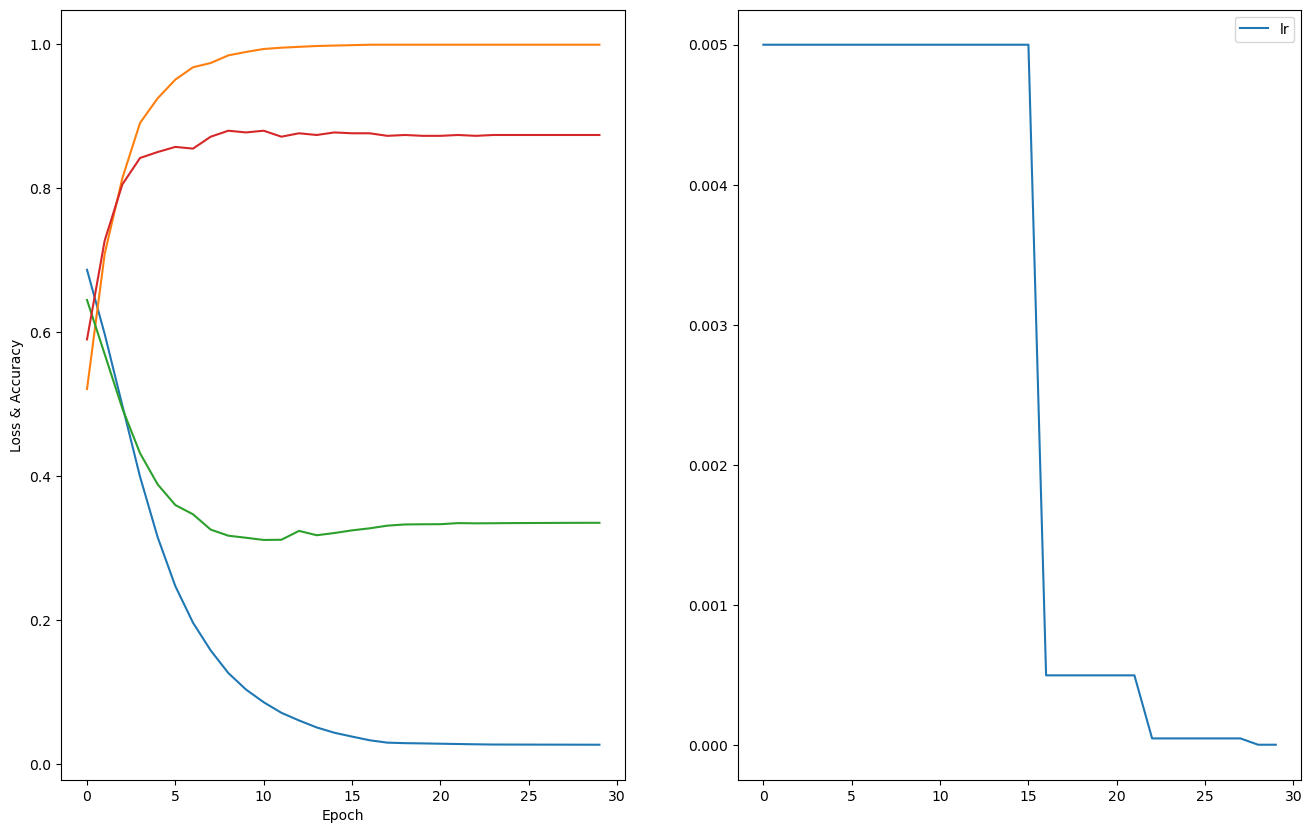

In [14]:
# 绘制误差曲线
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.plot([i[0] for i in records], label = 'Train Loss')
plt.plot([i[1] for i in records], label = 'Train Accuracy')
plt.plot([i[2] for i in records], label = 'Valid Loss')
plt.plot([i[3] for i in records], label = 'Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.subplot(1,2,2)
plt.plot([i[4] for i in records],label='lr')
plt.legend()
plt.show()

## 3.5 Transformer

### 3.5.1 数据加载器定义

In [15]:
class Vocab: 
    def __init__(self,input_tokens=None,min_freq_threshold=10,special_token_tag=False):
        if special_token_tag: # whether to use pad,begin of sentance,end of sentence,unknown tokens
            self.pad,self.bos,self.eos,self.unk  = 0,1,2,3
            tokens = ['<pad>','<bos>','<eos>','<unk>'] # ?
            self.special_tokens = ['<pad>','<bos>','<eos>','<unk>']
        else:
            self.unk = 0
            tokens = ['<unk>']
            self.special_tokens = ['<unk>']
        
        # when load, we can just initialze a nearly empty Vocab class
        # then load .pkl file to give the value of token2idx,idx2token
        if input_tokens is None: 
            return 
            
        # hashmap to count the tokens(key:token,value:freq)
        assert len(input_tokens),'0 length is not allowed'
        if isinstance(input_tokens[0],list): 
            input_tokens = [token for sentence in input_tokens for token in sentence if token not in self.special_tokens]
            tokens_freq = Counter(input_tokens)
        else:
            tokens_freq = Counter(input_tokens) 
        tokens_freq = sorted(tokens_freq.items(),key=lambda x:x[0]) # sort the tokens_freq dict by dictionary order
        tokens_freq = sorted(tokens_freq,key=lambda x:x[1],reverse=True) # sort the tokens_freq dict by freq order
        tokens_freq = dict(tokens_freq)
        # print(tokens_freq)
        
        # establish two hashmaps to transform index to token or reverse transform
        self.idx2token = []
        self.token2idx = dict()

        # filter the tokens whose freq is letter than min_freq_threshold
        tokens += list(filter(lambda x:tokens_freq[x]>min_freq_threshold,tokens_freq.keys()))
        # tokens += [token for token,freq in tokens_freq.items() if freq>=min_freq_threshold]

        # add the token to the two hashmaps
        i = 0 # 0 index is unknown token
        for token in tokens:
            self.idx2token.append(token)
            self.token2idx[token] = i
            i += 1
        assert len(self.idx2token) == len(self.token2idx),(len(self.idx2token),len(self.token2idx))
    
    def __len__(self):
        return len(self.idx2token)
    
    def __getitem__(self,tokens): 
        '''
        input : tokens(single char or list/tuple) 
        output : idx(then torch.nn.Embedding automatically transform to one-hot code)
        '''
        if (not isinstance(tokens,tuple)) and (not isinstance(tokens,list)):
            return self.token2idx.get(tokens,self.unk)
        else:
            # recursive call the __getitem__,until the token is a single char
            # use this strategy, we can process higher dim tensor such as :
            # [[a,b,c,...]](shape:[n1,n2]) or even [[[a,b,c],[d,e,f]]](shape:[n1,n2,n3])
            # the return shape is the same as the input
            return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        '''
            input the indices
            output the corresponding tokens
        '''
        if (not isinstance(indices,tuple)) and (not isinstance(indices,list)):
            return self.idx2token[indices]
        else:
            return [self.to_tokens(index) for index in indices]


In [16]:
class MyDataset(Dataset): # Transformer的输入句子的表示形式会不定长，要矩阵化存储需要指定一个max_len，不到的去做padding，超过的做truncationœ
    def __init__(self, data, split,load_vocab=False):
        super().__init__()
        self.load_tag = load_vocab
        if not load_vocab:
            self.vocab = data['vocab']
            self.pad_index = len(self.vocab.keys()) if '<pad>' not in self.vocab.keys() else self.vocab['<pad>']
        else:
            self.vocab = Vocab()
            save_dir = './model_vocab_glove'
            with open(os.path.join(save_dir,'token2idx.pkl'),'rb') as f:
                self.vocab.token2idx = pickle.load(f)
            
            with open(os.path.join(save_dir,'idx2token.pkl'),'rb') as f:
                self.vocab.idx2token = pickle.load(f)
            self.pad_index = len(self.vocab.token2idx.keys()) if '<pad>' not in self.vocab.token2idx.keys() else self.vocab.pad
            print('finish loading vocabulary')
        self.max_len = data.get('max_len', 30)
        self.make_dataset(data, split)

    def make_dataset(self, data, split):
        # Data是包含了整个数据集的数据
        # 而我们只需要训练集/验证集/测试集的数据
        # 我们按照划分基准split里面的下标来确定加载哪部分的数据
        self.dataset = []
        for idx in split:
            if not self.load_tag:
                this_sentence_id = data['sentences_id'][idx]
            else:
                this_sentence_id = self.vocab[data['sentences'][idx]]
            item = [
                torch.LongTensor(self.pad_data(this_sentence_id)),
                torch.LongTensor([data['labels'][idx]])
            ]
            self.dataset.append(item)

    def pad_data(self, seq):
        # 让序列长度最长只有max_len，不足就补pad，超过就截断
        if len(seq) < self.max_len:
            seq += [self.pad_index] * (self.max_len - len(seq))

        else:
            seq = seq[:self.max_len]
        return seq
    
    def get_pad_index(self):
        return self.pad_index
            
    def __getitem__(self, ix):
        # ix大于等于0，小于len(self.dataset)
        return self.dataset[ix]
    
    def __len__(self):
        # 一共有多少数据
        return len(self.dataset)

### 3.5.2 Transformer基础组件实现

In [17]:
import math
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super().__init__()
        assert hidden_size % num_heads == 0 # 维度需要能整除num-head才能采用多头注意力
        self.num_heads = num_heads
        self.attention_head_size = hidden_size // num_heads # 每个头的channel数
        self.all_head_size = hidden_size

        self.query = nn.Linear(hidden_size, hidden_size) # 大矩阵去实现，多个小矩阵不好并行
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor: # 输入维度是: [bs,seq-len,hidden-size] 输出得是[bs,num-head,len-seq,head_channel_size]
        new_x_shape = x.size()[:-1] + (self.num_heads, self.attention_head_size) # 把channel数拆了
        x = x.view(*new_x_shape) # [bsz, seq_len, n_head, head_size]
        # 绝不能直接 x = x.view(bs,n_head,seq_len,head_size] 这样数据的排列会有问题，这个stride是不正确的分块
        return x.permute(0, 2, 1, 3) # [bsz, n_head, seq_len, head_size]

    def forward(self, q, k, v, attention_mask=None):
        query = self.transpose_for_scores(self.query(q)) # [bsz, n_head, lq, head_size]
        key = self.transpose_for_scores(self.key(k))     # [bsz, n_head, lk, head_size]
        value = self.transpose_for_scores(self.value(v)) # [bsz, n_head, lv, head_size]
        
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) # [bsz, n_head, lq, lk]
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # normalize

        if attention_mask is not None: # mask attention
            if attention_mask.dim() == 2:
                attention_mask = attention_mask[:, None, None, :] # [bsz, 1, 1, lk]
            if attention_mask.dim() == 3:
                attention_mask = attention_mask[:, None, :, :] # [bsz, 1, lq, lk]
            attention_scores = attention_scores.masked_fill(attention_mask, -1e9) # 让mask处为-inf，softmax后该位置就是0

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs) # [bsz, n_head, lq, lk]，在attention map处做dropout

        context = torch.matmul(attention_probs, value) # [bsz, n_head, lq, head_size] need lv == lk
        context = context.permute(0, 2, 1, 3).contiguous() # [bsz, lq, n_head, head_size]

        new_context_shape = context.size()[:-2] + (self.all_head_size,)
        context = context.view(*new_context_shape) # [bsz, lq, dim_hidden]

        return context, attention_probs


class MultiHeadAttention(nn.Module): # 加入linear层和layer-norm
    def __init__(self, hidden_size, num_heads, attn_dropout, dropout):
        super().__init__()
        self.SDPA = ScaledDotProductAttention(hidden_size, num_heads, attn_dropout)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        
    def forward(self, hidden_states, attention_mask=None):
        q, k, v = hidden_states, hidden_states, hidden_states # 自注意力
        context, attention_probs = self.SDPA(q, k, v, attention_mask)
        context = self.dense(context)
        context = self.dropout(context) # layer-norm前做dropout

        hidden_states = self.LayerNorm(hidden_states + context)
        return hidden_states, attention_probs


class FeedForwardNetwork(nn.Module): # FFN（residual + MLP + layer-norm）
    def __init__(self, hidden_size, intermediate_size, dropout=.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(dropout) 
        )
        self.LN = nn.LayerNorm(hidden_size)
    
    def forward(self, x):
        return self.LN(x + self.net(x)) # norm层一般都是放在dropout、residual等计算完了再


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, intermediate_size, attn_dropout=.0, dropout=.0):
        super().__init__()
        self.mha = MultiHeadAttention(hidden_size, num_heads, attn_dropout, dropout)
        self.ffn = FeedForwardNetwork(hidden_size, intermediate_size, dropout)
    
    def forward(self, hidden_states, attention_mask):
        hidden_states, _ = self.mha(hidden_states, attention_mask)
        hidden_states = self.ffn(hidden_states)
        return hidden_states


class TransformerEncoder(nn.Module):
    def __init__(self, hidden_size, num_layers, num_heads, intermediate_size, attn_dropout=.0, dropout=.0):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, intermediate_size, attn_dropout, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, attn_mask):
        for layer in self.layers: # self-attention是同质结构，输入输出同shape，直接for就好
            x = layer(x, attn_mask)
        return x

### 3.5.3 模型定义

In [18]:
class TFModel(nn.Module):
    def __init__(self, 
            vocab_size, 
            hidden_size, 
            max_len, 
            pad_index, 
            num_class=2, 
            num_heads=4, 
            num_layers=1, 
            dropout=0.0, 
            attn_dropout=0.0,
            load_glove=False
    ):
        super().__init__()
        self.word_embs = nn.Embedding(vocab_size + 1, hidden_size, padding_idx=pad_index) # vocab-size +1 的+1是因为加了个<cls> token <pad>token在输入vocab-size的时候就加进去了
        self.position_embs = nn.Embedding(max_len+1, hidden_size) # 采用可学习的位置编码

        self.net = TransformerEncoder(
            hidden_size, 
            num_layers, 
            num_heads, 
            4 * hidden_size, 
            attn_dropout, 
            dropout
        )

        self.dropout = nn.Dropout(dropout)
        self.prj = nn.Linear(hidden_size, num_class)

        self.cls_index = vocab_size 
        self.pad_index = pad_index
        # print(self.cls_index,self.pad_index)

        if load_glove:
            model_path = './model_vocab_glove/model.pth'
            with open(model_path,'rb') as f:
                glove = torch.load(f)
                self.word_embs.weight.data[:-2,:] = glove.context.weight.data + glove.center.weight.data
                print((glove.context.weight.data + glove.center.weight.data)[:2,:])
        else:
            nn.init.normal_(self.word_embs.weight, std=.02)
        nn.init.normal_(self.position_embs.weight, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm): # element-wise-affine的参数指定，这样指定为identity变化
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def forward(self, input_ids):
        batch_size, device = input_ids.size(0), input_ids.device
        cls_tokens = torch.zeros((batch_size, 1)).to(input_ids.device) + self.cls_index
        cls_tokens = cls_tokens.long()
        input_ids = torch.cat((cls_tokens, input_ids), dim=1)

        embs = self.word_embs(input_ids)
        
        seq_len = embs.size(1)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device) 
        position_ids = position_ids[None, :]
        position_embs = self.position_embs(position_ids)

        embs = embs + position_embs # 加上位置编码
        embs = self.dropout(embs)
        
        attention_mask = (input_ids == self.pad_index) # (batch_size, seq_len)，padding token不要计算注意力，所以mask掉
        hidden_states = self.net(embs, attention_mask)
        
        cls_hidden_state = hidden_states[:, 0, :]
        cls_hidden_state = self.dropout(cls_hidden_state)
        
        output = self.prj(cls_hidden_state)
        output = F.log_softmax(output, dim=-1)
        
        return output
    

### 3.5.4 运行

In [19]:
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token
hidden_size = 16
num_heads = 4
num_layers = 1
attn_dropout = 0.1
dropout = 0.3

data['max_len'] = 100

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset)
# 模型实例化
model = TFModel(
    vocab_size,
    hidden_size, 
    data['max_len'],
    pad_index=train_loader.dataset.get_pad_index(), 
    num_heads=num_heads,
    num_layers=num_layers,
    attn_dropout=attn_dropout,
    dropout=dropout
)
# 打印模型
print(model)
# 损失函数 -- 交叉熵
crit = torch.nn.NLLLoss()
# 优化方法
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

records = []
best_val_acc = 0.
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

    scheduler.step(vali_loss)
    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
    best_val_acc = max(best_val_acc,vali_acc)
    if best_val_acc == vali_acc:
        best_val_model = model
# 测试
_, test_acc = evaluate(best_val_model, test_loader, crit, device)
print('测试集正确率：', test_acc)

TFModel(
  (word_embs): Embedding(6692, 16, padding_idx=6690)
  (position_embs): Embedding(101, 16)
  (net): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (mha): MultiHeadAttention(
          (SDPA): ScaledDotProductAttention(
            (query): Linear(in_features=16, out_features=16, bias=True)
            (key): Linear(in_features=16, out_features=16, bias=True)
            (value): Linear(in_features=16, out_features=16, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dense): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (LayerNorm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): FeedForwardNetwork(
          (net): Sequential(
            (0): Linear(in_features=16, out_features=64, bias=True)
            (1): Dropout(p=0.3, inplace=False)
            (2): ReLU()
            (3): Linear(in_features=64, 

### 3.5.5 训练过程损失&准确率的变化

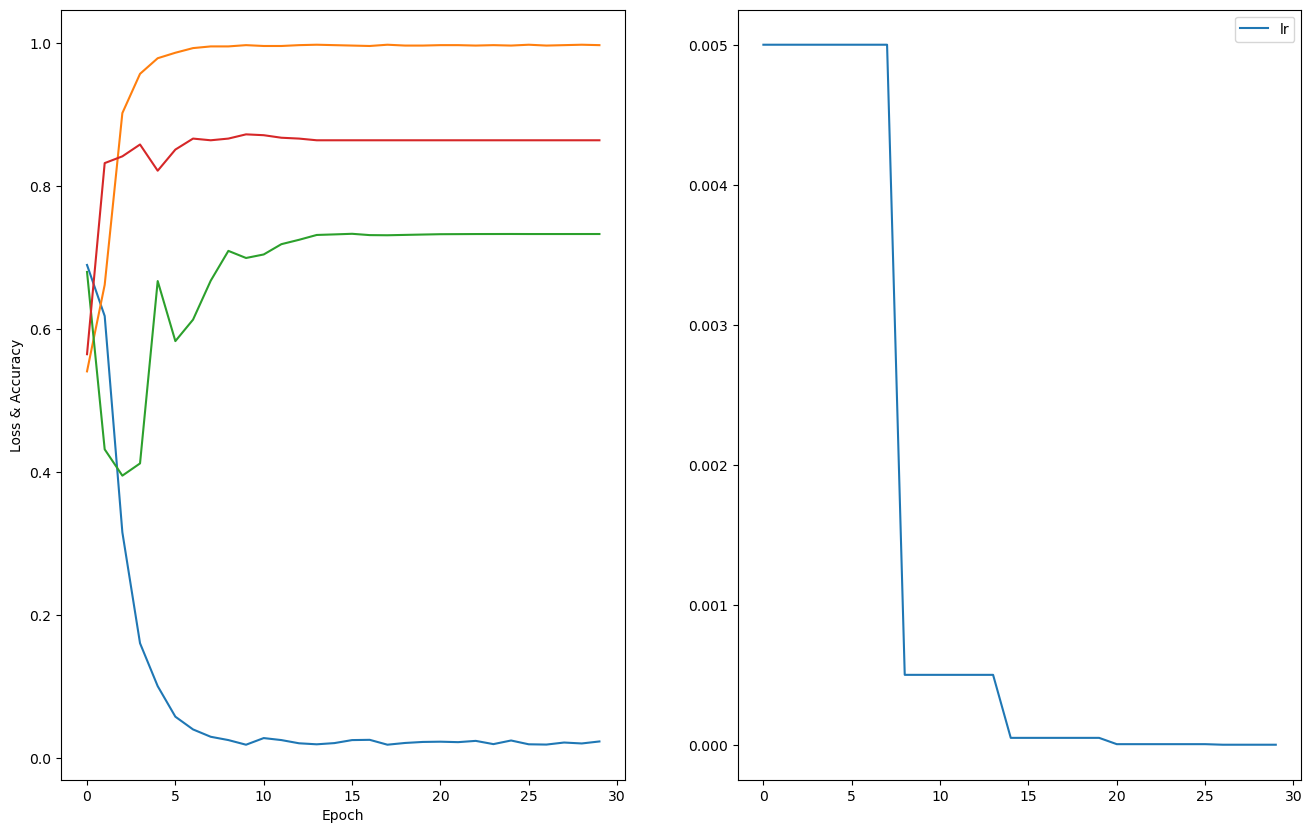

In [20]:
# 绘制误差曲线
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.plot([i[0] for i in records], label = 'Train Loss')
plt.plot([i[1] for i in records], label = 'Train Accuracy')
plt.plot([i[2] for i in records], label = 'Valid Loss')
plt.plot([i[3] for i in records], label = 'Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.subplot(1,2,2)
plt.plot([i[4] for i in records],label='lr')
plt.legend()
plt.show()

### 3.5.6 加载Glove预训练模型

In [21]:
def init_weights(m,mode='zero'):
    if type(m) == nn.Embedding:
        if mode =='xavier':
            nn.init.xavier_normal_(m.weight)
        else:
            nn.init.zeros_(m.weight)

class GloVe(nn.Module):
    def __init__(self,vocab_size,embedding_size) -> None:
        super(GloVe,self).__init__()
        self.context = nn.Embedding(vocab_size,embedding_size)
        self.center = nn.Embedding(vocab_size,embedding_size)
        self.context_bias = nn.Embedding(vocab_size,1)
        self.center_bias = nn.Embedding(vocab_size,1)
        init_weights(self.context,mode='xavier')
        init_weights(self.center,mode='xavier')
        init_weights(self.center_bias)
        init_weights(self.context_bias)

    
    def forward(self,center, all_contexts): # input.shape: B,N,vocab_size
        bs,max_len = all_contexts.shape
        contexts = self.context(all_contexts) # shape (B,N_context,embedding_size)
        centers = self.center(center) # shape (B,1,embedding_size)
        contexts_bias = self.context_bias(all_contexts) # shape (B,N_context,1)
        centers_bias = self.center_bias(center) # shape (B,1,1)
        similarity = centers @ contexts.transpose(1,2) # shape:[B,1,N_context]
        similarity = similarity.reshape(bs,max_len)
        centers_bias = centers_bias.reshape(bs,1)
        contexts_bias = contexts_bias.reshape(bs,max_len)
        output = contexts_bias + similarity + centers_bias
        return output

In [22]:
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token
hidden_size = 16
num_heads = 4
num_layers = 1
attn_dropout = 0.1
dropout = 0.3

data['max_len'] = 100

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset,load_tag=True)
# 模型实例化
model = TFModel(
    vocab_size,
    hidden_size, 
    data['max_len'],
    pad_index=train_loader.dataset.get_pad_index(), 
    num_heads=num_heads,
    num_layers=num_layers,
    attn_dropout=attn_dropout,
    dropout=dropout,
    load_glove=True
)
print(model.word_embs.weight.data[:2,:])
# 打印模型
# print(model)
# 损失函数 -- 交叉熵
crit = torch.nn.NLLLoss()
# 优化方法
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

records = []
best_val_acc = 0.
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

    scheduler.step(vali_loss)
    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
    best_val_acc = max(best_val_acc,vali_acc)
    if best_val_acc == vali_acc:
            best_val_model = model
# 测试
_, test_acc = evaluate(best_val_model, test_loader, crit, device)
print('测试集正确率：', test_acc)

finish loading vocabulary
finish loading vocabulary
finish loading vocabulary
tensor([[-0.9399,  1.4614, -1.3322, -0.1741, -1.4984, -1.7529, -1.4392,  4.0450,
         -0.7645, -0.5165,  2.4163, -1.2320,  1.5399, -2.7519,  1.7697, -1.9805],
        [-1.9900,  2.2208, -0.8959, -1.8451, -0.3068, -2.5838, -1.4648,  2.4096,
         -0.6057, -1.3303,  0.9983, -1.3355,  0.4345, -1.4977,  1.5219, -0.8654]],
       device='cuda:0')
tensor([[-0.9399,  1.4614, -1.3322, -0.1741, -1.4984, -1.7529, -1.4392,  4.0450,
         -0.7645, -0.5165,  2.4163, -1.2320,  1.5399, -2.7519,  1.7697, -1.9805],
        [-1.9900,  2.2208, -0.8959, -1.8451, -0.3068, -2.5838, -1.4648,  2.4096,
         -0.6057, -1.3303,  0.9983, -1.3355,  0.4345, -1.4977,  1.5219, -0.8654]])
第0轮，训练集损失：0.69, 训练集准确率：0.55, 验证集损失：0.67, 验证集准确率: 0.57
第1轮，训练集损失：0.66, 训练集准确率：0.62, 验证集损失：0.60, 验证集准确率: 0.70
第2轮，训练集损失：0.60, 训练集准确率：0.69, 验证集损失：0.58, 验证集准确率: 0.70
第3轮，训练集损失：0.57, 训练集准确率：0.72, 验证集损失：0.52, 验证集准确率: 0.74
第4轮，训练集损失：0.49, 训练集准确率：0.77,

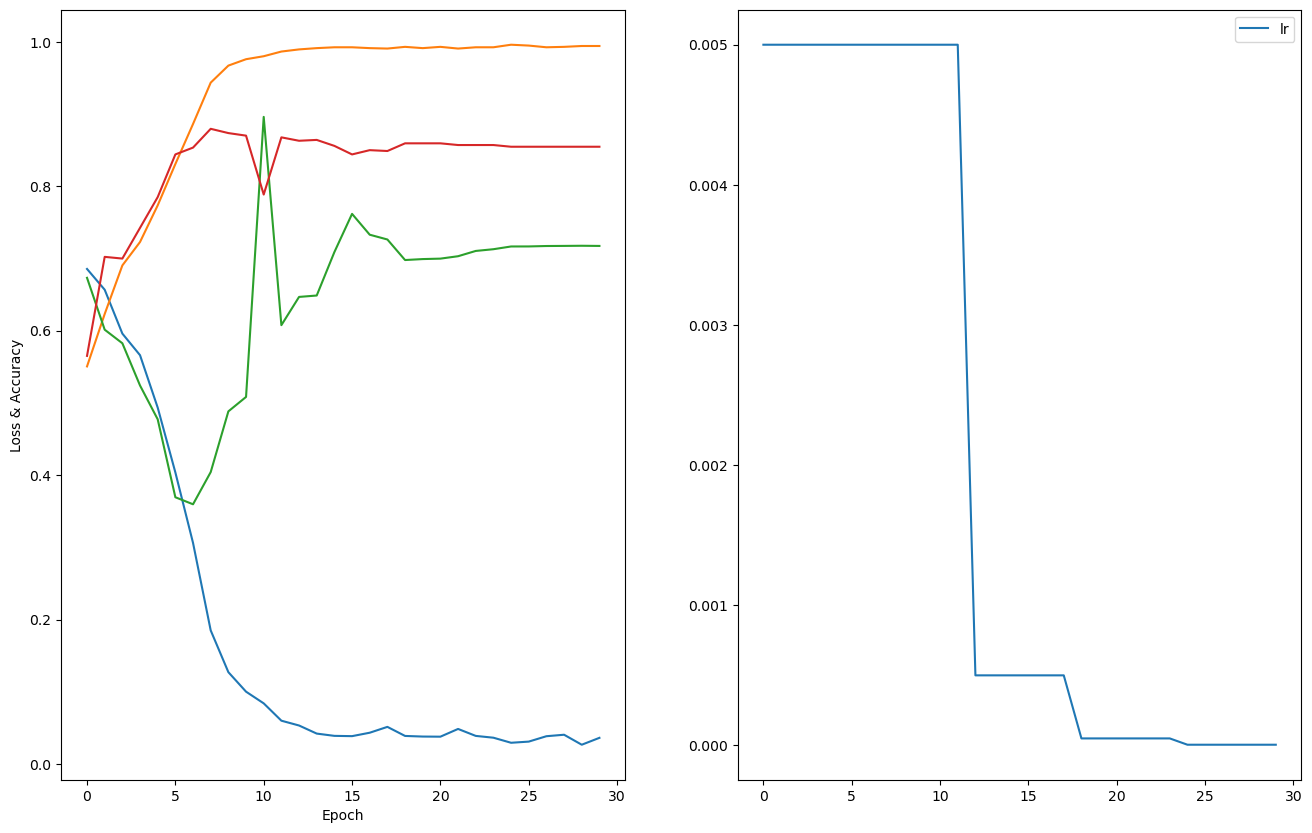

In [23]:
# 绘制误差曲线
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.plot([i[0] for i in records], label = 'Train Loss')
plt.plot([i[1] for i in records], label = 'Train Accuracy')
plt.plot([i[2] for i in records], label = 'Valid Loss')
plt.plot([i[3] for i in records], label = 'Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.subplot(1,2,2)
plt.plot([i[4] for i in records],label='lr')
plt.legend()
plt.show()

In [24]:
class Pretrainedembs_MLP(nn.Module):
    def __init__(self,embs_size,vocab_size,pad_index,dropout,use_distance_weight=False):
        super().__init__()
        self.word_embs = nn.Embedding(vocab_size,embs_size)
        self.mlp = nn.Sequential(
            # nn.Conv1d(embs_size,embs_size,1,1,0),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(embs_size,2,1,1,0)
        )
        self.pad_index = pad_index
        self.GAP = nn.AdaptiveAvgPool1d(1)
        if not use_distance_weight:
            model_path = f'./model_vocab_glove_for_mlp/model_{embs_size}.pth'
            with open(model_path,'rb') as f:
                glove = torch.load(f)
            self.word_embs.weight.data[:-1,:] = glove.context.weight.data + glove.center.weight.data
        else:
            glove_path = f'./model_vocab_glove_for_mlp_dw/model_{embs_size}.pth'
            with open(glove_path,'rb') as f:
                glove = torch.load(f)
            self.word_embs.weight.data[:-1,:] = glove.context.weight.data + glove.center.weight.data
    
    def forward(self,x,log_softmax=True):
        bs = x.shape[0]
        pad_mask = x!=self.pad_index
        embed = self.word_embs(x)
        embed = embed.permute(0,2,1).contiguous()
        cls = self.GAP(self.mlp(embed)*pad_mask[:,None,:]).view(bs,2)
        if log_softmax:
            cls = F.log_softmax(cls,dim=1)
        return cls
    

In [25]:
class Model_Ensemble(nn.Module):
    def __init__(self,models):
        super().__init__()
        self.model_lst = models
        self.linear_weight = nn.Linear(2*len(self.model_lst),2,bias=False)
    def forward(self,x):
        bs = x.shape[0]
        scores = []
        for model in self.model_lst:
            model.eval()
            scores.append(model(x,log_softmax=False))
        finale_score = self.linear_weight(torch.cat(scores,dim=1))
        return finale_score

In [26]:
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token

data['max_len'] = 100

pairs = [(32,0.),(64,0.),(96,0.6),(16,0)]

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset,load_tag=True)
model_lst = []
# 模型实例化
for embs_size,dropout in pairs:
    model = Pretrainedembs_MLP(embs_size,vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,use_distance_weight=False)
    # print(model.word_embs.weight.data[:2,:])
    # 打印模型
    # print(model)
    # 损失函数 -- 交叉熵
    crit = torch.nn.NLLLoss()
    # 优化方法
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

    records = []
    best_val_acc = 0.
    for epoch in range(num_epochs):
        # 训练
        train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
        # 验证
        vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

        # scheduler.step(vali_loss)

        # 储存信息以便可视化
        records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
        best_val_acc = max(best_val_acc,vali_acc)
        if best_val_acc == vali_acc:
                best_val_model = model
    # 测试
    _, test_acc = evaluate(best_val_model, test_loader, crit, device)
    print(f'dim: {embs_size} 模型的测试集正确率：', test_acc)
    model_lst.append(best_val_model)
ensemble_model = Model_Ensemble(model_lst)
w_optimizer = torch.optim.Adam(ensemble_model.linear_weight.parameters(),lr=learning_rate)
# w_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(w_optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)
crit = nn.CrossEntropyLoss()
best_acc = 0.
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(ensemble_model, train_loader, crit, w_optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(ensemble_model, vali_loader, crit, device)


    # w_scheduler.step(vali_loss)
    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
    best_val_acc = max(best_val_acc,vali_acc)
    if best_val_acc == vali_acc:
        best_val_ensemble_model = ensemble_model

_, test_acc = evaluate(best_val_ensemble_model, test_loader, crit, device)
print(test_acc)

finish loading vocabulary
finish loading vocabulary
finish loading vocabulary
dim: 32 模型的测试集正确率： 0.8569739952718676
dim: 64 模型的测试集正确率： 0.8723404255319149
dim: 96 模型的测试集正确率： 0.8628841607565012
dim: 16 模型的测试集正确率： 0.8368794326241135
第0轮，训练集损失：0.28, 训练集准确率：0.99, 验证集损失：0.33, 验证集准确率: 0.87
第1轮，训练集损失：0.14, 训练集准确率：0.99, 验证集损失：0.30, 验证集准确率: 0.87
第2轮，训练集损失：0.10, 训练集准确率：0.99, 验证集损失：0.30, 验证集准确率: 0.88
第3轮，训练集损失：0.08, 训练集准确率：0.99, 验证集损失：0.30, 验证集准确率: 0.88
第4轮，训练集损失：0.08, 训练集准确率：0.99, 验证集损失：0.30, 验证集准确率: 0.87
第5轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.31, 验证集准确率: 0.88
第6轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.31, 验证集准确率: 0.88
第7轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.31, 验证集准确率: 0.88
第8轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.32, 验证集准确率: 0.88
第9轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.32, 验证集准确率: 0.88
第10轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.32, 验证集准确率: 0.88
第11轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.33, 验证集准确率: 0.88
第12轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.33, 验证集准确率: 0.88
第13轮，训练集损失：0.05, 训练集准确率：0.99, 验证集损失：0.33, 验证集准确率: 0.88
第14轮，训练集损失

In [27]:
# 训练集、验证集一起训练
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token

data['max_len'] = 100

pairs = [(32,0.),(64,0.),(96,0.6),(16,0)]

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset,load_tag=True)
model_lst = []
# 模型实例化
for embs_size,dropout in pairs:
    model = Pretrainedembs_MLP(embs_size,vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,use_distance_weight=False)
    crit = torch.nn.NLLLoss()
    # 优化方法
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    records = []
    for epoch in range(num_epochs):
        # 训练
        train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
        # 验证
        vali_loss, vali_acc = training(model, vali_loader, crit, optimizer,device)
    # 测试
    _, test_acc = evaluate(model, test_loader, crit, device)
    print(f'dim: {embs_size} 模型的测试集正确率：', test_acc)
    model_lst.append(model)
ensemble_model = Model_Ensemble(model_lst)
w_optimizer = torch.optim.Adam(ensemble_model.linear_weight.parameters(),lr=learning_rate)
crit = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(ensemble_model, train_loader, crit, w_optimizer, device)
    # 验证
    vali_loss, vali_acc = training(ensemble_model, vali_loader, crit, w_optimizer,device)

    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])

_, test_acc = evaluate(ensemble_model, test_loader, crit, device)
print(test_acc)

finish loading vocabulary
finish loading vocabulary
finish loading vocabulary
dim: 32 模型的测试集正确率： 0.8770685579196218
dim: 64 模型的测试集正确率： 0.8806146572104019
dim: 96 模型的测试集正确率： 0.8817966903073287
dim: 16 模型的测试集正确率： 0.8546099290780141
第0轮，训练集损失：0.14, 训练集准确率：0.99, 验证集损失：0.08, 验证集准确率: 0.99
第1轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.05, 验证集准确率: 0.99
第2轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.04, 验证集准确率: 0.99
第3轮，训练集损失：0.05, 训练集准确率：0.99, 验证集损失：0.04, 验证集准确率: 0.99
第4轮，训练集损失：0.05, 训练集准确率：0.99, 验证集损失：0.04, 验证集准确率: 0.99
第5轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.04, 验证集准确率: 0.99
第6轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第7轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第8轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第9轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第10轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第11轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第12轮，训练集损失：0.04, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第13轮，训练集损失：0.03, 训练集准确率：0.99, 验证集损失：0.03, 验证集准确率: 0.99
第14轮，训练集损失

In [28]:
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token
embs_size = 16

data['max_len'] = 100

dropout_list = [0.,.1,.2,.3,.4,.5,.6,.7,.8,.9]
# pairs = [(16,0.5),(32,0.4),(64,0.5),(96,0.8)]

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset,load_tag=True)
# 模型实例化
for i,dropout in enumerate(dropout_list):
    model = Pretrainedembs_MLP(embs_size,vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,use_distance_weight=True)
    # print(model.word_embs.weight.data[:2,:])
    # 打印模型
    # print(model)
    # 损失函数 -- 交叉熵
    crit = torch.nn.NLLLoss()
    # 优化方法
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

    records = []
    best_val_acc = 0.
    for epoch in range(num_epochs):
        # 训练
        train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
        # 验证
        vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

        # scheduler.step(vali_loss)
        # 打印消息
        # print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        #     epoch, train_loss, train_acc, vali_loss, vali_acc))
        # 储存信息以便可视化
        records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
        best_val_acc = max(best_val_acc,vali_acc)
        if best_val_acc == vali_acc:
                best_val_model = model
    # 测试
    _, test_acc = evaluate(best_val_model, test_loader, crit, device)
    print(dropout,'测试集正确率：', test_acc)

finish loading vocabulary
finish loading vocabulary
finish loading vocabulary
0.0 测试集正确率： 0.8286052009456265
0.1 测试集正确率： 0.8262411347517731
0.2 测试集正确率： 0.7836879432624113
0.3 测试集正确率： 0.8226950354609929
0.4 测试集正确率： 0.8215130023640662
0.5 测试集正确率： 0.7860520094562647
0.6 测试集正确率： 0.8286052009456265
0.7 测试集正确率： 0.8191489361702128
0.8 测试集正确率： 0.8085106382978723
0.9 测试集正确率： 0.8002364066193853


In [29]:
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token

data['max_len'] = 100

pairs = [(32,0.),(64,0.3),(96,0.2),(16,0)]

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset,load_tag=True)
model_lst = []
# 模型实例化
for embs_size,dropout in pairs:
    model = Pretrainedembs_MLP(embs_size,vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,use_distance_weight=True)
    # print(model.word_embs.weight.data[:2,:])
    # 打印模型
    # print(model)
    # 损失函数 -- 交叉熵
    crit = torch.nn.NLLLoss()
    # 优化方法
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

    records = []
    best_val_acc = 0.
    for epoch in range(num_epochs):
        # 训练
        train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
        # 验证
        vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)

        # scheduler.step(vali_loss)

        # 储存信息以便可视化
        records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
        best_val_acc = max(best_val_acc,vali_acc)
        if best_val_acc == vali_acc:
                best_val_model = model
    # 测试
    _, test_acc = evaluate(best_val_model, test_loader, crit, device)
    print(f'dim: {embs_size} 模型的测试集正确率：', test_acc)
    model_lst.append(best_val_model)
ensemble_model = Model_Ensemble(model_lst)
w_optimizer = torch.optim.Adam(ensemble_model.linear_weight.parameters(),lr=learning_rate)
# w_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(w_optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)
crit = nn.CrossEntropyLoss()
best_acc = 0.
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(ensemble_model, train_loader, crit, w_optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(ensemble_model, vali_loader, crit, device)


    # w_scheduler.step(vali_loss)
    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])
    best_val_acc = max(best_val_acc,vali_acc)
    if best_val_acc == vali_acc:
        best_val_ensemble_model = ensemble_model

_, test_acc = evaluate(best_val_ensemble_model, test_loader, crit, device)
print(test_acc)

finish loading vocabulary
finish loading vocabulary
finish loading vocabulary
dim: 32 模型的测试集正确率： 0.8557919621749409
dim: 64 模型的测试集正确率： 0.8617021276595744
dim: 96 模型的测试集正确率： 0.8735224586288416
dim: 16 模型的测试集正确率： 0.8250591016548463
第0轮，训练集损失：0.36, 训练集准确率：0.93, 验证集损失：0.35, 验证集准确率: 0.86
第1轮，训练集损失：0.17, 训练集准确率：0.97, 验证集损失：0.31, 验证集准确率: 0.87
第2轮，训练集损失：0.13, 训练集准确率：0.97, 验证集损失：0.31, 验证集准确率: 0.87
第3轮，训练集损失：0.11, 训练集准确率：0.98, 验证集损失：0.31, 验证集准确率: 0.87
第4轮，训练集损失：0.10, 训练集准确率：0.98, 验证集损失：0.31, 验证集准确率: 0.87
第5轮，训练集损失：0.09, 训练集准确率：0.98, 验证集损失：0.31, 验证集准确率: 0.87
第6轮，训练集损失：0.08, 训练集准确率：0.98, 验证集损失：0.31, 验证集准确率: 0.87
第7轮，训练集损失：0.08, 训练集准确率：0.98, 验证集损失：0.32, 验证集准确率: 0.87
第8轮，训练集损失：0.08, 训练集准确率：0.98, 验证集损失：0.32, 验证集准确率: 0.87
第9轮，训练集损失：0.07, 训练集准确率：0.98, 验证集损失：0.33, 验证集准确率: 0.87
第10轮，训练集损失：0.07, 训练集准确率：0.98, 验证集损失：0.33, 验证集准确率: 0.87
第11轮，训练集损失：0.07, 训练集准确率：0.98, 验证集损失：0.33, 验证集准确率: 0.87
第12轮，训练集损失：0.07, 训练集准确率：0.98, 验证集损失：0.33, 验证集准确率: 0.87
第13轮，训练集损失：0.06, 训练集准确率：0.98, 验证集损失：0.34, 验证集准确率: 0.87
第14轮，训练集损失

In [30]:
# 训练集、验证集一起训练
# 参数
num_epochs = 30
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1 # +1是因为<pad> token

data['max_len'] = 100

pairs = [(32,0.),(64,0.3),(96,0.6),(16,0)]

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset,load_tag=True)
model_lst = []
# 模型实例化
for embs_size,dropout in pairs:
    model = Pretrainedembs_MLP(embs_size,vocab_size,pad_index = train_loader.dataset.get_pad_index(),dropout=dropout,use_distance_weight=True)
    crit = torch.nn.NLLLoss()
    # 优化方法
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

    records = []
    for epoch in range(num_epochs):
        # 训练
        train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
        # 验证
        vali_loss, vali_acc = training(model, vali_loader, crit, optimizer,device)
    # 测试
    _, test_acc = evaluate(model, test_loader, crit, device)
    print(f'dim: {embs_size} 模型的测试集正确率：', test_acc)
    model_lst.append(model)
ensemble_model = Model_Ensemble(model_lst)
w_optimizer = torch.optim.Adam(ensemble_model.linear_weight.parameters(),lr=learning_rate)
crit = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(ensemble_model, train_loader, crit, w_optimizer, device)
    # 验证
    vali_loss, vali_acc = training(ensemble_model, vali_loader, crit, w_optimizer,device)

    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc,optimizer.param_groups[0]['lr']])

_, test_acc = evaluate(ensemble_model, test_loader, crit, device)
print(test_acc)

finish loading vocabulary
finish loading vocabulary
finish loading vocabulary
dim: 32 模型的测试集正确率： 0.8829787234042553
dim: 64 模型的测试集正确率： 0.8794326241134752
dim: 96 模型的测试集正确率： 0.8806146572104019
dim: 16 模型的测试集正确率： 0.8380614657210402
第0轮，训练集损失：0.72, 训练集准确率：0.54, 验证集损失：0.27, 验证集准确率: 0.99
第1轮，训练集损失：0.18, 训练集准确率：0.99, 验证集损失：0.13, 验证集准确率: 0.99
第2轮，训练集损失：0.12, 训练集准确率：0.99, 验证集损失：0.10, 验证集准确率: 0.99
第3轮，训练集损失：0.10, 训练集准确率：0.99, 验证集损失：0.09, 验证集准确率: 0.99
第4轮，训练集损失：0.09, 训练集准确率：0.99, 验证集损失：0.08, 验证集准确率: 0.99
第5轮，训练集损失：0.08, 训练集准确率：0.99, 验证集损失：0.07, 验证集准确率: 0.99
第6轮，训练集损失：0.08, 训练集准确率：0.99, 验证集损失：0.07, 验证集准确率: 0.99
第7轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.06, 验证集准确率: 0.99
第8轮，训练集损失：0.07, 训练集准确率：0.99, 验证集损失：0.06, 验证集准确率: 0.99
第9轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.06, 验证集准确率: 0.99
第10轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.05, 验证集准确率: 0.99
第11轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.05, 验证集准确率: 0.99
第12轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.05, 验证集准确率: 0.99
第13轮，训练集损失：0.06, 训练集准确率：0.99, 验证集损失：0.05, 验证集准确率: 0.99
第14轮，训练集损失